# Import

In [71]:
import gymnasium as gym
import seaborn as sns
import os
from collections import deque, Counter, namedtuple, defaultdict
import random
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import torch
from torch import nn
from torch.nn import init
import torch.nn.functional as F
from torch.distributions import Categorical
import math
from itertools import count
from tqdm import tqdm
import numpy as np
import time
import uuid

from stable_baselines3.common.atari_wrappers import ClipRewardEnv, FireResetEnv, MaxAndSkipEnv, NoopResetEnv

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)



# Global params

In [72]:
ENV_ARGS = {
    'id': "BreakoutNoFrameskip-v4"
}
NUM_ENVS = 3
SEED = 1
LR = 3e-4
NUM_STEPS = 2048
NUM_ITERATIONS = 1000
GAMMA = 0.99
GAE_LAMBDA = 0.95
UPDATE_EPOCHS = 10
CLIP_COEF = 0.2 # the epsilon in KL divergece in PPO paper
ENTROPY_COEF = 0.0
VF_COEF = 0.5
MAX_GRAD_NORM = 0.5
MINI_BATCH_COUNT = 32
UPDATE_PLOTS = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device = ', DEVICE)

#output directory
ROOT = os.getcwd()
OUTPUT = os.path.join(ROOT, 'output')

if os.path.exists(OUTPUT) == False:
    os.makedirs(OUTPUT)

#seeding
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device =  cpu


In [73]:
# gym.envs.registration.registry.keys()

In [74]:
def make_env(**env_args):
    env = gym.make(**env_args)
    # env = gym.wrappers.FlattenObservation(env)
    env = gym.wrappers.RecordEpisodeStatistics(env)
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip = 4)

    env = ClipRewardEnv(env)
    env = gym.wrappers.ResizeObservation(env, (84,84)) 
    env = gym.wrappers.GrayScaleObservation(env) 
    env = gym.wrappers.FrameStack(env, 4) 
    return env

# Test env

100%|██████████| 10/10 [00:01<00:00,  5.02it/s]


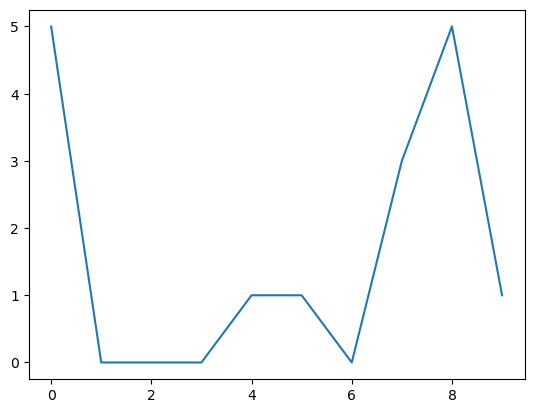

In [75]:
env = make_env(**ENV_ARGS)
obs, info = env.reset()

rewards = []
for ep in tqdm(range(10)):
    obs, info = env.reset()
    total_reward = 0

    for t in count():
        action = env.action_space.sample()
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        if terminated or truncated: 
            break
    
    rewards.append(total_reward)

sns.lineplot(y = rewards, x = list(range(len(rewards))))
plt.show()
env.close()

# Actor and Critic Net

In [76]:
def layer_init(layer: nn.Linear, std = np.sqrt(2), bias_const = 0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class ActorNet(nn.Module):

    def __init__(self, state_size, action_size, device, hidden_size = 64, lr = 1e-3):
        super().__init__()
        self.device = device

        self.network = nn.Sequential(
            layer_init(nn.Conv2d(4, 32, 8, stride = 4)),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, 4, stride = 2)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, 3, stride = 1)),
            nn.ReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(64 * 7 * 7, hidden_size)),
            nn.ReLU(),
            layer_init(nn.Linear(hidden_size, action_size), std = 0.01),
            nn.Softmax()
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr = lr)

    def forward(self, X):
        return self.network(X)
    
    def act(self, state):
        state = torch.tensor(state).float().unsqueeze(0).to(self.device)
        probs = self(state/255.0)
        m = Categorical(probs)
        #we want to sample an action from the probability distribution over actions.
        action = m.sample()
        log_prob = m.log_prob(action)
        return action.item(), log_prob
    
    def learn(self, saved_log_probs, advantage):
        actor_loss = (-saved_log_probs * advantage.detach()).sum()
        self.optimizer.zero_grad()
        actor_loss.backward()
        self.optimizer.step()

In [77]:
class CriticNet(nn.Module):
    def __init__(self, state_size, device, hidden_size = 64, lr = 1e-3):
        super().__init__()
        self.network = nn.Sequential(
            layer_init(nn.Conv2d(4, 32, 8, stride = 4)),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, 4, stride = 2)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, 3, stride = 1)),
            nn.ReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(64 * 7 * 7, hidden_size)),
            nn.ReLU(),
            layer_init(nn.Linear(hidden_size, 1), std = 0.01),
            nn.Softmax()
        )
        self.device = device
        self.to(device)
        self.optimizer = torch.optim.Adam(self.parameters(), lr = lr)

    def forward(self, state):
        state = torch.tensor(state).float().unsqueeze(0).to(self.device)
        return self.network(state/255.0)
    
    def learn(self, returns, state_values):
        critic_loss = F.mse_loss(returns, state_values)
        self.optimizer.zero_grad()
        critic_loss.backward()
        self.optimizer.step()


In [78]:
# Test model
env = make_env(**ENV_ARGS)
obs, info = env.reset()
state_size = obs.shape
action_size = env.action_space.n

print('state size = ', state_size)
print('action size = ', action_size)

actor = ActorNet(state_size, action_size, device = DEVICE)
critic = CriticNet(state_size, device = DEVICE)

obs = torch.tensor(obs).float()

action, action_prob = actor.act(obs)
print('action = ', action)
print('action prob = ', action_prob)

value = critic(obs)
print('value = ', value)

env.close()

state size =  (4, 84, 84)
action size =  4
action =  3
action prob =  tensor([-1.3890], grad_fn=<SqueezeBackward1>)
value =  tensor([[1.]], grad_fn=<SoftmaxBackward0>)


# Compute returns

In [79]:
def compute_returns(rewards, gamma):
    returns = deque(maxlen = len(rewards))
    #compute cummulative reward
    num_steps = len(rewards)

    for t in reversed(range(num_steps)):
        G_t = returns[0] if len(returns) > 0 else 0
        returns.appendleft(gamma * G_t + rewards[t])

    #standardization of returns to make training more stable
    eps = np.finfo(np.float32).eps.item()
    returns = torch.tensor(returns).float()
    returns = (returns - returns.mean())/(returns.std() + eps)

    return returns


In [80]:
print(np.finfo(np.float32).eps.item())

1.1920928955078125e-07


# A2C algo

In [64]:
def a2c(env, actor: ActorNet, critic: CriticNet, training_epochs, max_t, gamma, label = 'baseline', plot_update_freq = 10):

    SAVE_PATH = os.path.join(OUTPUT, ENV_ARGS['id'], label)
    FIG_SAVE_PATH = os.path.join(SAVE_PATH, 'plot.png')
    if os.path.exists(SAVE_PATH) == False:
        os.makedirs(SAVE_PATH)
    
    scores_deque = deque(maxlen = 100)
    history = defaultdict(list)
    loop = tqdm(range(training_epochs))
    best_score = -float('inf')
    global_steps = 0

    action_freq = Counter()

    for e in loop:

        saved_log_probs = []
        rewards = []
        state, info = env.reset()
        dones = []
        state_values = []

        for t in count(): 
            done = False
            action, log_prob = actor.act(state)
            saved_log_probs.append(log_prob)

            state_value = critic(state)
            state_values.append(state_value)

            action_freq[action] += 1

            state, reward, terminated, truncated, info = env.step(action)
            rewards.append(reward)

            if terminated or truncated:
                done = True
                break
                
            dones.append(done)

            global_steps += 1
        
        #update actor
        scores_deque.append(sum(rewards))
        avg_reward = np.mean(scores_deque)

        history['reward'].append(avg_reward)

        returns = compute_returns(rewards, gamma)

        state_values = torch.cat(state_values)
        saved_log_probs = torch.cat(saved_log_probs)

        #advantage function
        advantage = returns - state_values
        actor.learn(saved_log_probs, advantage)
        critic.learn(returns, state_values)


        #statistics and saving checkpoint
        loop.set_description(f'avg reward = {avg_reward:.2f}, total steps = {global_steps}, actions={action_freq.most_common()}')

        if best_score <= avg_reward:
            best_score = avg_reward
            torch.save(actor, os.path.join(SAVE_PATH, 'actor.checkpoint.torch'))
            torch.save(critic, os.path.join(SAVE_PATH, 'critic.checkpoint.torch'))
        
        if e % plot_update_freq == 0:
            plot(history, save_path=FIG_SAVE_PATH)
        
    plot(history, show=True, save_path=FIG_SAVE_PATH)
    torch.save(actor, os.path.join(SAVE_PATH, 'actor.final.torch'))
    torch.save(critic, os.path.join(SAVE_PATH, 'critic.final.torch'))

    return history

def plot(history, show = False, save_path = None):
    sns.lineplot(y = history['reward'], x = list(range(len(history['reward']))))

    if save_path != None:
        plt.savefig(save_path)
    if show:
        plt.show()
        
    plt.clf()
    plt.close()

# Train

state size =  4
action size =  4


avg reward = 1.24, total steps = 209195, actions=[(1, 74245), (0, 62606), (2, 55923), (3, 17421)]: 100%|██████████| 1000/1000 [37:23<00:00,  2.24s/it]


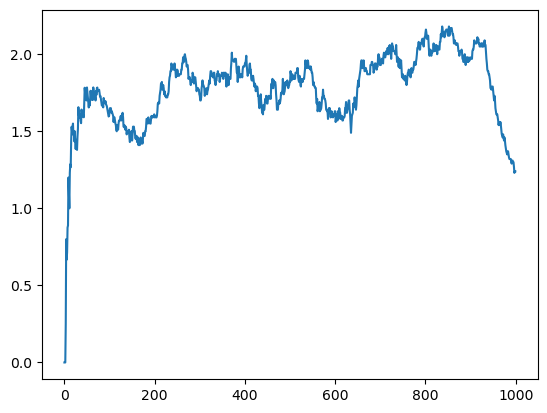

In [65]:
training_epochs = 1000
max_t = 1000
gamma = 0.99
lr = 1e-4
hidden_size = 512

device = DEVICE

env = make_env(**ENV_ARGS)
obs, info = env.reset()
state_size = len(obs)
action_size = env.action_space.n
print('state size = ', state_size)
print('action size = ', action_size)

# model = PolicyNet(state_size, action_size, hidden_size = 16, device = 'cpu')
actor = ActorNet(state_size, action_size, hidden_size = hidden_size, device = device, lr = lr)
critic = CriticNet(state_size, hidden_size = hidden_size, device = device, lr = lr)

a2c(env, actor, critic, training_epochs=training_epochs, max_t = max_t, gamma = gamma)

env.close()

state size =  4
action size =  4


avg reward = 1.87, total steps = 988910, actions=[(1, 307277), (2, 285940), (0, 240465), (3, 160228)]: 100%|██████████| 5000/5000 [2:58:40<00:00,  2.14s/it]  


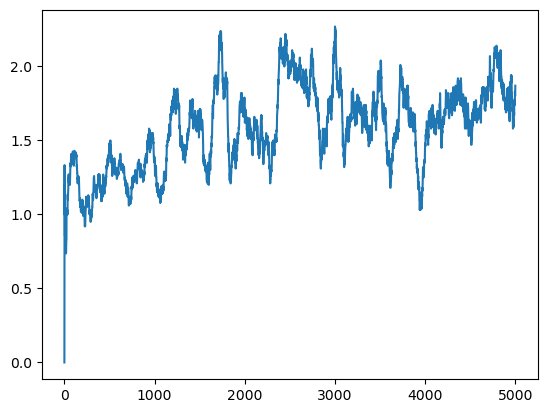

In [67]:
training_epochs = 5000
max_t = 1000
gamma = 0.99
lr = 1e-4
hidden_size = 512

device = DEVICE

env = make_env(**ENV_ARGS)
obs, info = env.reset()
state_size = len(obs)
action_size = env.action_space.n
print('state size = ', state_size)
print('action size = ', action_size)

# model = PolicyNet(state_size, action_size, hidden_size = 16, device = 'cpu')
actor = ActorNet(state_size, action_size, hidden_size = hidden_size, device = device, lr = lr)
critic = CriticNet(state_size, hidden_size = hidden_size, device = device, lr = lr)

a2c(env, actor, critic, training_epochs=training_epochs, max_t = max_t, gamma = gamma)

env.close()

# Evaluate

In [92]:
def evaluate(agent, device = DEVICE, episodes = 10):
    env = make_env(**ENV_ARGS)
    agent.eval()
    total_rewards = []
    next_obs, _ = env.reset()

    for e in range(episodes):
        next_obs, _ = env.reset()
        total_reward = 0

        for t in count(): 
            next_obs = torch.Tensor(next_obs).to(device)
            action, log_prob, = agent.act(next_obs)

            next_obs, reward, terminated, truncated, info = env.step(action)
            total_reward += reward

            if terminated or truncated:
                print(total_reward)
                break
        
        total_rewards.append(total_reward)
    sns.lineplot(y = total_rewards, x = list(range(len(total_rewards))))
    return total_rewards

1.0
0.0
2.0
0.0
2.0
1.0
2.0
0.0
5.0
0.0


[1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 2.0, 0.0, 5.0, 0.0]

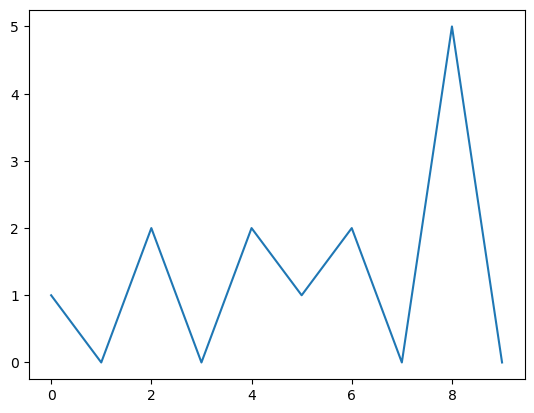

In [93]:
LOAD_PATH = os.path.join(OUTPUT, 'BreakoutNoFrameskip-v4', 'baseline', 'actor.checkpoint.torch')
agent = torch.load(LOAD_PATH)

agent.eval()

evaluate(agent)




# References

https://medium.com/deeplearningmadeeasy/advantage-actor-critic-continuous-case-implementation-f55ce5da6b4c